In [1]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from rich.jupyter import print as rprint
from torchvision.datasets import ImageFolder
from rich.progress import Progress, SpinnerColumn, TextColumn, TaskProgressColumn, TimeRemainingColumn, BarColumn, ProgressColumn, MofNCompleteColumn

# custom imports
from mobilevit import MobileViT

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# progress printing helpers
class TaskIterationsPerSecondColumn(ProgressColumn):

    def __init__(self, emoji: str, color: str, unit: str):
        super(TaskIterationsPerSecondColumn, self).__init__()
        self.emoji = emoji
        self.color = color
        self.unit = unit


    def render(self, task):
        return f"{self.emoji} [{self.color}]{(task.speed or 0):>02.01f} {self.unit}"

In [3]:
# load image dataset

# hyperparameters
image_dim = (1024, 1024)
batch_size = 2
epochs = 100
early_stopping = 4
model_checkpoint = 'mobilevit.pth'

# trainset transforms
train_transforms = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# note: horizontal flip applied during training only
# validset/testset transforms
valid_transforms = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.ToTensor(),
])

# generate train and valid datasets
train_dir = "new_dataset/train"
valid_dir = "new_dataset/val"
test_dir = "new_dataset/test"

train_dataset = ImageFolder(train_dir, train_transforms)
valid_dataset = ImageFolder(valid_dir, valid_transforms)
test_dataset = ImageFolder(test_dir, valid_transforms)

# generate train and valid dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# store idx2class
idx2class = {v: k for k,v in train_dataset.class_to_idx.items()}

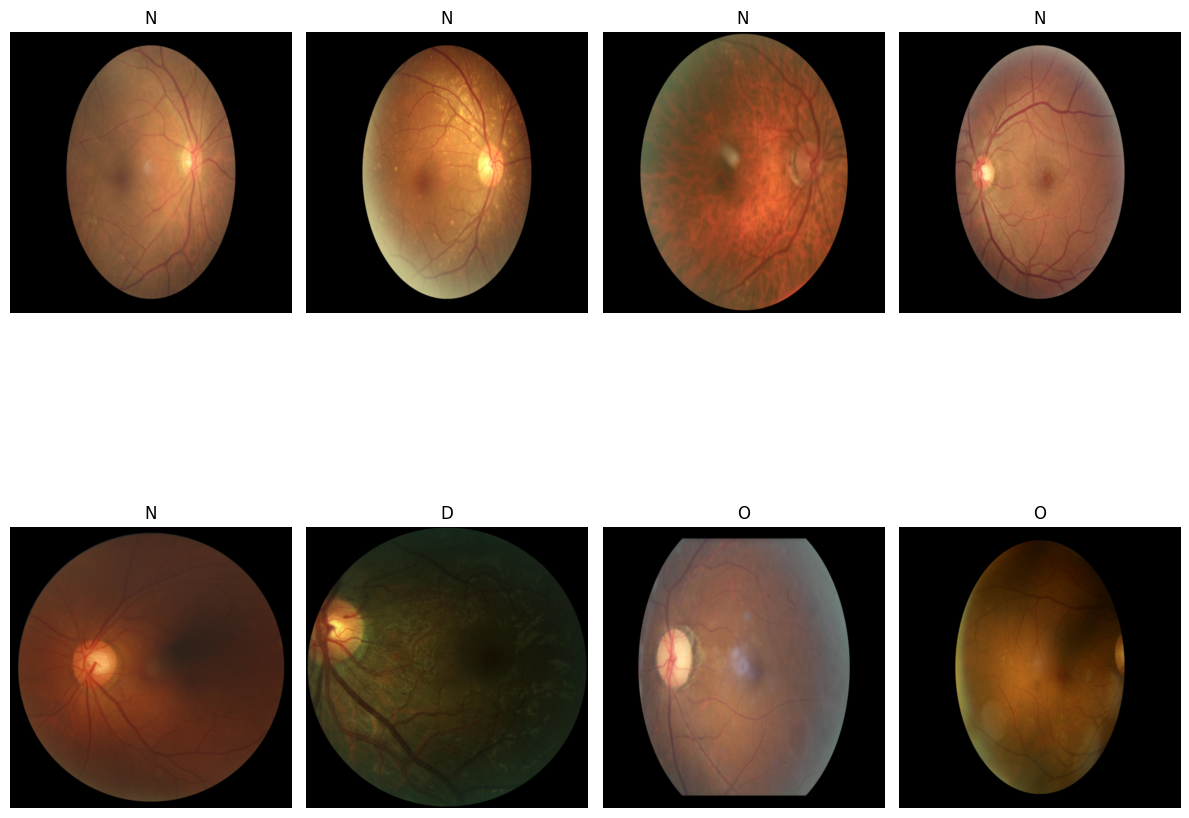

In [4]:
# plot a batch
def print_grid(images: torch.tensor, labels: torch.tensor):
    # gather idx2class mapping
    idx2class = {v: k for k,v in train_dataset.class_to_idx.items()}

    # determine batch size
    batch_size = len(images)

    # determine number of image rows
    n_cols = 4
    n_rows = batch_size // 4
    if batch_size % 4 != 0:
    	n_rows += 1

    # create figure object to hold the grid
    fig = plt.figure(figsize=(12, 12))

    # plot images with labels
    ax = list()
    for inx in range(batch_size):
        # gather image + label
        image, label = images[inx], labels[inx]

        # convert image and label to numpy
        image = image.numpy()
        label = idx2class[label.numpy().tolist()]

        # transpose image to properly convert to numpy format
        # since torch uses (channel, height, width) compared to
        # (height, width, channels) of OpenCV/numpy
        image = np.transpose(image, (1, 2, 0))

        # append subplot
        ax.append(fig.add_subplot(n_rows, n_cols, inx+1))

        # append label to subplot
        ax[-1].set_title(label)

        # switch of axes
        ax[-1].axis('off')

        # display image
        plt.imshow(image)

    # ensure correct padding between subplots
    fig.tight_layout()

    # display full grid
    plt.savefig('sample.png')
    plt.show()


# gather one iteration of data from dataloader
iter_data = iter(train_dataloader)
images, labels = next(iter_data)

print_grid(images=images, labels=labels)

In [5]:
# define model - MobileViT 'S' architecture
dims = [144, 192, 240]
channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
model = MobileViT(image_dim, dims, channels, num_classes=len(train_dataset.classes))

In [6]:
# define loss function
criterion = torch.nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

In [13]:

def train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, model_checkpoint, epochs=10, early_stopping=5):
    # determine training device
    training_device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[magenta3][b]Training Device:[/b] {training_device}")

    # move model to the correct device
    model.to(training_device)

    # start model training
    no_improvement_epochs = 0
    prev_validation_loss = np.inf

    # Lists to store training and validation losses for each epoch
    train_losses = []
    valid_losses = []

    with Progress(
        TextColumn("[progress.description]{task.description}"),
        SpinnerColumn(spinner_name="dots"),
        BarColumn(bar_width=None),
        TaskProgressColumn(show_speed=True),
        TimeRemainingColumn(elapsed_when_finished=True),
        TextColumn("[yellow]{task.completed}/{task.total}"),
        TaskIterationsPerSecondColumn(emoji=":earth_asia:", color="indian_red", unit="It/s"),
        expand=True,
    ) as progress:
        # create epoch task
        epoch_task = progress.add_task(description='[bold green_yellow]Epoch Progress', total=epochs)

        # loop over the dataset multiple times
        total_batches = len(train_dataloader)
        for epoch in range(epochs):
            # create batch task
            batch_task = progress.add_task(description='[gold1]Batch Progress', total=total_batches)

            # run training
            running_loss = 0.0
            for data in train_dataloader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(training_device), labels.to(training_device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # gather running loss
                running_loss += loss.item()

                # update progress bar
                progress.update(task_id=batch_task, advance=1)

            # remove batch progress bar
            progress.remove_task(task_id=batch_task)

            # put model to evaluation mode for validation testing
            model.eval()

            # run validation
            with torch.no_grad():
                validation_loss = 0.0
                for data in valid_dataloader:
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    inputs, labels = inputs.to(training_device), labels.to(training_device)

                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # gather validation loss
                    validation_loss += loss.item()

            # save checkpoint, if better than prev. validation loss
            if validation_loss <= prev_validation_loss:
                # set validation loss
                prev_validation_loss = validation_loss

                # save model checkpoint
                torch.save(model.state_dict(), model_checkpoint)

                # reset early stopping counter
                no_improvement_epochs = 0

            else:
                # increment early stopping counter
                no_improvement_epochs += 1

            # print statistics at end of training epoch
            average_train_loss = running_loss / len(train_dataloader)
            train_losses.append(average_train_loss)
            print(f'[EPOCH: {epoch + 1:>3d}] loss: {average_train_loss:>01.09f}  {"🏆" if not no_improvement_epochs else ""}')

            # update progress bar
            progress.update(task_id=epoch_task, advance=1)

            # early stopping check
            if no_improvement_epochs >= early_stopping:
                break

            # put model back to training mode for further training
            model.train()

        # Plotting the training loss over epochs
        plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.show()

    # save the weights of the last epoch
    last_model_checkpoint = model_checkpoint.split('.')
    last_model_checkpoint = "".join(last_model_checkpoint[:-1] + ['_last', '.'] + last_model_checkpoint[-1:])
    torch.save(model.state_dict(), last_model_checkpoint)

    print()
    print(f'[bold chartreuse3]Finished Training, after {epoch + 1} Epochs.')


In [14]:
# Assuming you have defined your model, dataloaders, criterion, and optimizer
train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, model_checkpoint, epochs=10, early_stopping=5)


Output()

[magenta3][b]Training Device:[/b] cuda


[EPOCH:   1] loss: 0.693772996  🏆

KeyboardInterrupt: 

In [10]:
# load the best model weight
del model
model = MobileViT(image_dim, dims, channels, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load(model_checkpoint))
model.to(training_device)
model.eval()

# test model performance on testset
correct = 0
total = 0
accuracy_dict = {k: {'total': 0, 'correct': 0} for k in idx2class}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(training_device), labels.to(training_device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            accuracy_dict[labels[i].cpu().item()]['total'] += 1
            if predicted[i] == labels[i]:
                accuracy_dict[labels[i].cpu().item()]['correct'] += 1

rprint(f'Accuracy of the network ({model_checkpoint}) on {len(test_dataset)} test images: {100 * correct // total} %')
print()
#for class_idx, class_stats in accuracy_dict.items():
#    print(f"{classes[class_idx].upper():12s}:  {class_stats['correct']}/{class_stats['total']} \t {(class_stats['correct']/class_stats['total'])*100:3.02f}%")

Accuracy of the network (mobilevit.pth) on 633 test images: 51 %

In [11]:
# load the last model weight
del model
model = MobileViT(image_dim, dims, channels, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load(last_model_checkpoint))
model.to(training_device)
model.eval()

# test model performance on testset
correct = 0
total = 0
accuracy_dict = {k: {'total': 0, 'correct': 0} for k in idx2class}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(training_device), labels.to(training_device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            accuracy_dict[labels[i].cpu().item()]['total'] += 1
            if predicted[i] == labels[i]:
                accuracy_dict[labels[i].cpu().item()]['correct'] += 1

rprint(f'Accuracy of the network ({last_model_checkpoint}) on {len(test_dataset)} test images: {100 * correct // total} %')
print()
#for class_idx, class_stats in accuracy_dict.items():
#    print(f"{classes[class_idx].upper():12s}:  {class_stats['correct']}/{class_stats['total']} \t {(class_stats['correct']/class_stats['total'])*100:3.02f}%")

Accuracy of the network (mobilevit_last.pth) on 633 test images: 51 %